# Visualizing High-Performance Gradient Boosting with XGBoost and Yellowbrick

In this post we'll explore how to evaluate the performance of a gradient boosting classifier from the [`xgboost` library](https://github.com/dmlc/xgboost) on the [poker hand dataset](http://archive.ics.uci.edu/ml/datasets/Poker+Hand) using visual diagnostic tools from [`Yellowbrick`](http://www.scikit-yb.org/en/latest/). Even though Yellowbrick is designed to work with [`scikit-learn`](http://scikit-learn.org/stable/index.html), it turns out that it works well with any machine learning library that provides a sklearn wrapper module.

![poker_deck](https://raw.githubusercontent.com/rebeccabilbro/rebeccabilbro.github.io/master/images/2018-06-12-poker-deck.jpg)
Image credit: ["cards"](https://flic.kr/p/62xpc7) by bl0ndeeo2, Creative Commons License



## What is Boosting?    

In supervised machine learning, [gradient boosting]((https://en.wikipedia.org/wiki/Gradient_boosting) is an additive training technique for iteratively ensembling weak models into stronger ones. Traditional tree-based methods allow us to scale complexity with increasingly deep trees and more complex branching, but have a tendency to overfit to the training data. Gradient boosting enables us to build complex models using ensembles of shallow trees, which individually have low variance and high bias, but together can incrementally decrease bias via gradient descent. A preliminary, naive model is fit, its error is computed, and the error is used to train the next model, and so on. In this way, the algorithm aims to optimize the loss function over function space by iteratively fitting models that point in the negative gradient direction. Gradient boosting models are also invariant to scaling inputs, meaning that they do not require careful feature normalization, as do some models (like k-nearest neighbors and support vector machines).

In general, when I am prototyping a machine learning application, I leverage the Scikit-Learn API to compare many estimators and a few different hyperparameters. Because I work in a biweekly scrum cycle context, I'm less concerned with optimatization (at least at the outset), and more focused on proving out whether or not a new dataset is well-suited to prediction. Scikit-Learn does have [an implementation of gradient boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), but in this post, I'll be using [`xgboost`](https://github.com/dmlc/xgboost), which provides implementations of parallel tree boosting and also has a sklearn wrapper.

Conveniently, there are an increasing number of Python libraries that expose convenient Scikit-Learn wrappers for custom estimators (e.g. Gensim, Keras, etc). This means that they can be used inside Scikit-Learn [pipelines](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) (if you've never experimented with pipelines or feature unions, here's [great post](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html) by Zac Stewart on leveraging them in your ML workflow).   

Compared to the Scikit-Learn implementation (which tend to be geared towards small-to-medium-sized datasets), `xgboost` is unique in that it is written to scale seamlessly to large datasets and a Spark context (it evolved out of a [research project](http://dmlc.cs.washington.edu/xgboost.html) by [Tianqi Chen](https://github.com/tqchen) and [Carlos Guestrin](https://homes.cs.washington.edu/~guestrin/)). This enables us to quickly compare not only the standard Scikit-Learn estimators but also ones that may more easily scale, should we find good preliminary success with our prototype.



## What is Yellowbrick?    

The [Yellowbrick](http://www.scikit-yb.org) library is a new Python visualization package that extends the Scikit-Learn API to incorporate visual diagnostics into machine learning -- and has over the last years become an essential part of my own ML workflow. It's my go-to tool for determining whether I'm on track through my feature analysis -> model selection -> hyperparameter tuning cycles, and for deciding what to do next based on my current results.


## About the Data

The [dataset](http://archive.ics.uci.edu/ml/datasets/Poker+Hand) we'll be exploring in this post is the Poker Hand data from the UCI Machine Learning Repository. The premise is that given some features of a hand of cards in a poker game, we should be able to predict the type of hand.

Each record in the dataset is an example of a hand consisting of five playing cards drawn from a standard deck of 52. Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. The target column describes the hand, with the possibilities being:    

    0: Nothing in hand; not a recognized poker hand     
    1: One pair; one pair of equal ranks within five cards     
    2: Two pairs; two pairs of equal ranks within five cards     
    3: Three of a kind; three equal ranks within five cards     
    4: Straight; five cards, sequentially ranked with no gaps     
    5: Flush; five cards with the same suit     
    6: Full house; pair + different rank three of a kind     
    7: Four of a kind; four equal ranks within five cards     
    8: Straight flush; straight + flush     
    9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush     
    
The order of cards is important, which is why there are 480 possible Royal Flush hands as compared to 4 (one for each suit).

In [1]:
%matplotlib inline

In [2]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError

In [3]:
def download_data(data_url, dir_path):
    """
    Convenience function that uses the requests library to retrieve data 
    given a url to the dataset and a directory folder on your computer.
    """
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    response = requests.get(data_url)
    name = os.path.basename(data_url)
    with open(os.path.join(dir_path, name), 'wb') as f:
        f.write(response.content)
    
    return name

In [4]:
# Specify the directory where I want to store the data on my machine, and the URL for the data
base_folder = 'data'
poker = 'http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data'
dataset_name = download_data(poker, base_folder)

# Read the data from disk into a Pandas dataframe
poker_df = pd.read_csv(os.path.join(base_folder, dataset_name))

# Manually label the columns and classes based on the dataset description from the UCI Repository
poker_df.columns = ['first_suit', 'first_rank', 'second_suit', 'second_rank', 'third_suit', 'third_rank',
                   'fourth_suit', 'fourth_rank', 'fifth_suit', 'fifth_rank', 'hand']
classes = ['zilch', 'one_pair', 'two_pair', 'three_of_a_kind', 'straight', 'flush', 'full_house',
           'four_of_a_kind', 'straight_flush', 'royal_flush']

# Separate the data into features (X) and targets (y)
X = poker_df.iloc[:,0:9]
y = poker_df['hand']

Now that the data is downloaded and has been read into a dataframe, I'm going to start by fitting a preliminary `XGBClassifier()` model from the `xgboost.sklearn` module, and using the [Yellowbrick `ClassBalance` plot](http://www.scikit-yb.org/en/latest/api/classifier/class_balance.html) to evaluate whether there are any class imbalance issues that may effect the modeling processing. Anecdotally, I know that certain poker hands are pretty rare, so we should be expecting to see at least some imbalance; the `ClassBalance` report will tell us just how severe it is.

## Class Balance Plot

First we instantiate the `ClassBalance` visualizer, passing in the xgboost estimator, desired figure size in pixels, and class names. We then call `fit` on the visualizer, which will also call the xgboost (or sklearn) model's internal fit method. The Yellowbrick `score` method calls Scikit-Learn classification scoring means to evaluate the internal model, and `poof` shows the plot.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


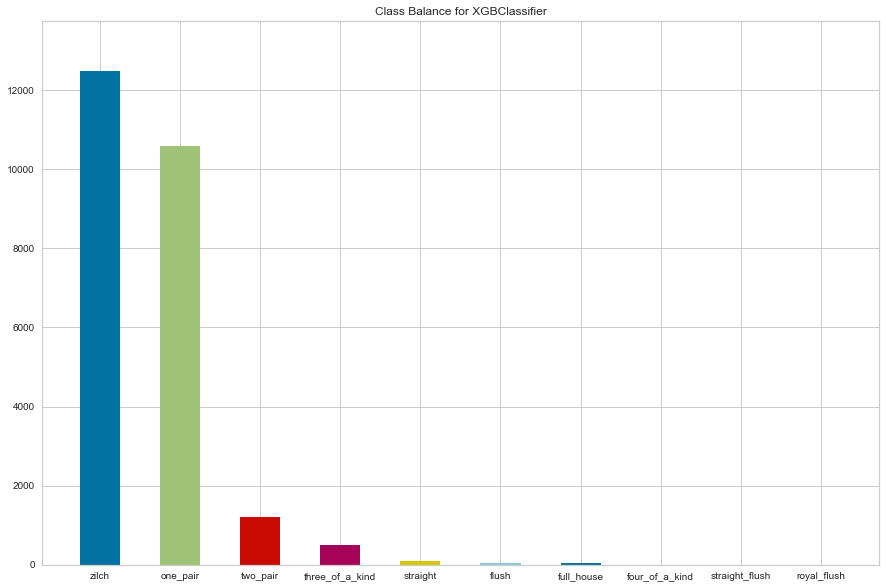

In [5]:
balance = ClassBalance(XGBClassifier(), size=(1080, 720), classes=classes)

balance.fit(X, y)   
balance.score(X, y)
b = balance.poof()

One issue we can observe from the above `ClassBalance` report is that several of our classes - such as the Royal Flush and Straight Flush - are so rare that Scikit-Learn raises a warning that "Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples." This is means that our classifier will be unlikely to successfully predict those hands, no matter how much we try to scale complexity. 

As a result we'll use Pandas to convert these rare classes into a single class that includes Flush or better.

In [6]:
poker_df.loc[poker_df['hand'] >= 5, 'hand'] = 8
y = poker_df['hand']

classes = ['zilch', 'one_pair', 'two_pair', 'three_of_a_kind', 'straight', 'flush_or_better']

Now we'll break our data into training and test splits, so that we evaluate our fitted model on data that it wasn't trained on. This will allow us to see how well our xgboost model is balancing the bias/variance tradeoff.

In [7]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.5)

clf = XGBClassifier(max_depth=5)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Now that our model is fitted, let's evaluate its performance using some of Yellowbrick's visualizers for classification.

## ROCAUC 

Receiver Operating Characteristic (ROC) curves are a measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the models’ sensitivity and specificity. The ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.

This leads to another metric, area under the curve (AUC), a computation of the relationship between false positives and true positives. The higher the AUC, the better the model generally is. However, it is also important to inspect the “steepness” of the curve, as this describes the maximization of the true positive rate while minimizing the false positive rate. Generalizing “steepness” usually leads to discussions about convexity, which we do not get into here.

The cool thing about Yellowbrick's implementation of [ROCAUC](http://www.scikit-yb.org/en/latest/api/classifier/rocauc.html) is that we can evaluate a multi-class classifier. Yellowbrick does this by plotting the ROCAUC curve for each class as though it were it's own binary classifier, all on one plot.

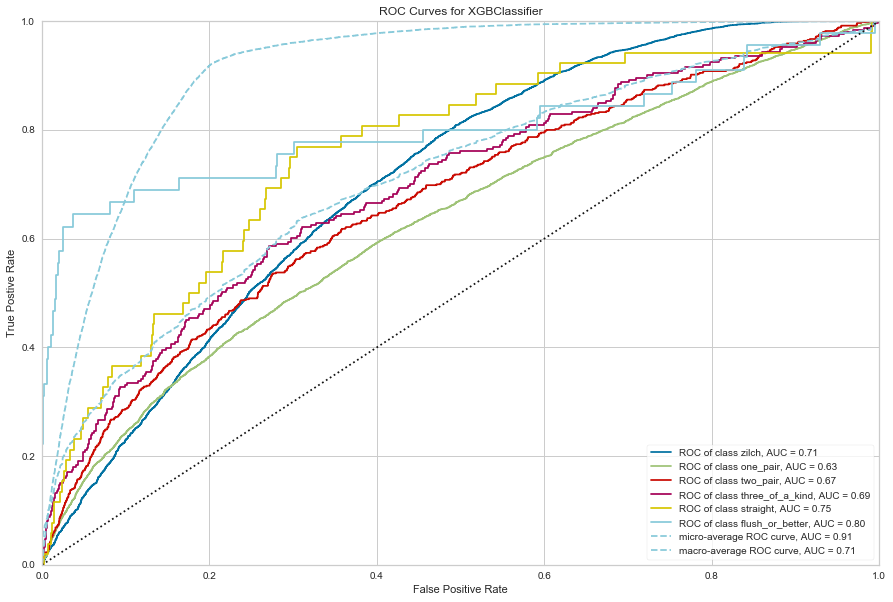

In [8]:
rocauc = ROCAUC(clf, size=(1080, 720), classes=classes)

rocauc.score(X_test, y_test)  
r = rocauc.poof()

## Classification Report Heatmap

The classification report displays the precision, recall, and F1 scores for the model. In order to support easier interpretation and problem detection, Yellowbrick's implementation of [ClassificationReport](http://www.scikit-yb.org/en/latest/api/classifier/classification_report.html) integrates numerical scores with a color-coded heatmap. 

The classification report shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem. Visual classification reports are used to compare classification models to select models that are “redder”, e.g. have stronger classification metrics or that are more balanced. (Note that Yellowbrick also makes it pretty easy to [change the colormap](https://stackoverflow.com/questions/48580031/changing-yellowbrick-visiualization-colors) if needed.)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


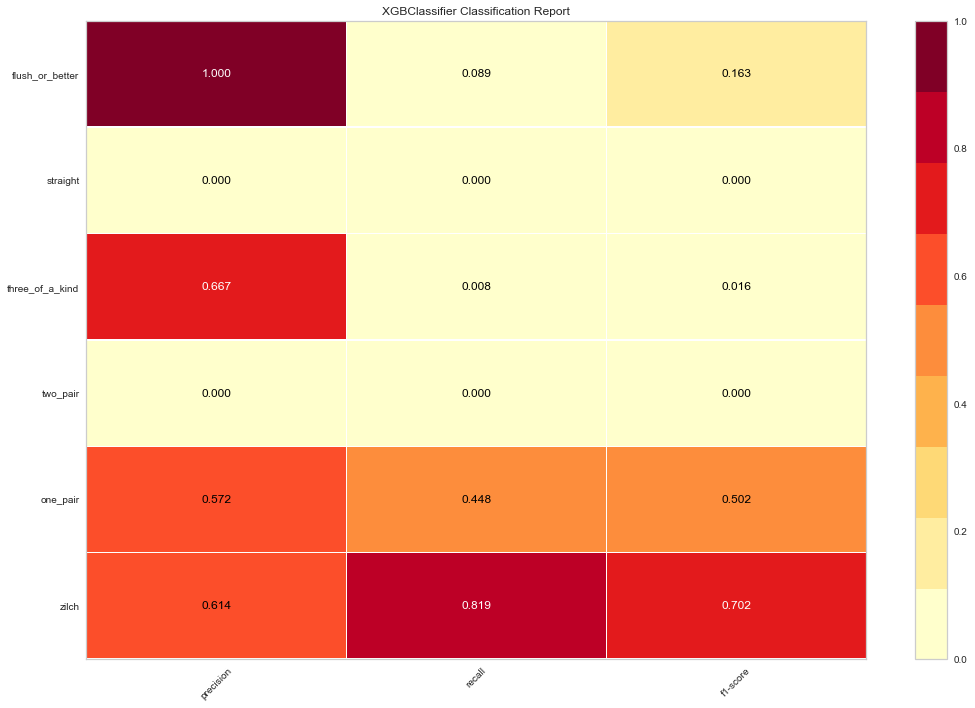

In [9]:
report = ClassificationReport(clf, size=(1080, 720), classes=classes)

report.score(X_test, y_test)
c = report.poof()

## Class Prediction Error

The Yellowbrick [Class Prediction Error chart](http://www.scikit-yb.org/en/latest/api/classifier/class_prediction_error.html) that shows the support for each class in the fitted classification model displayed as a stacked bar. Each bar is segmented to show the distribution of predicted classes for each class. It is initialized with a fitted model and generates a class prediction error chart on draw. For my part, I find `ClassPredictionError` a convenient and easier-to-interpret alternative to the standard [confusion matrix (which Yellowbrick also has a visualizer for)](http://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


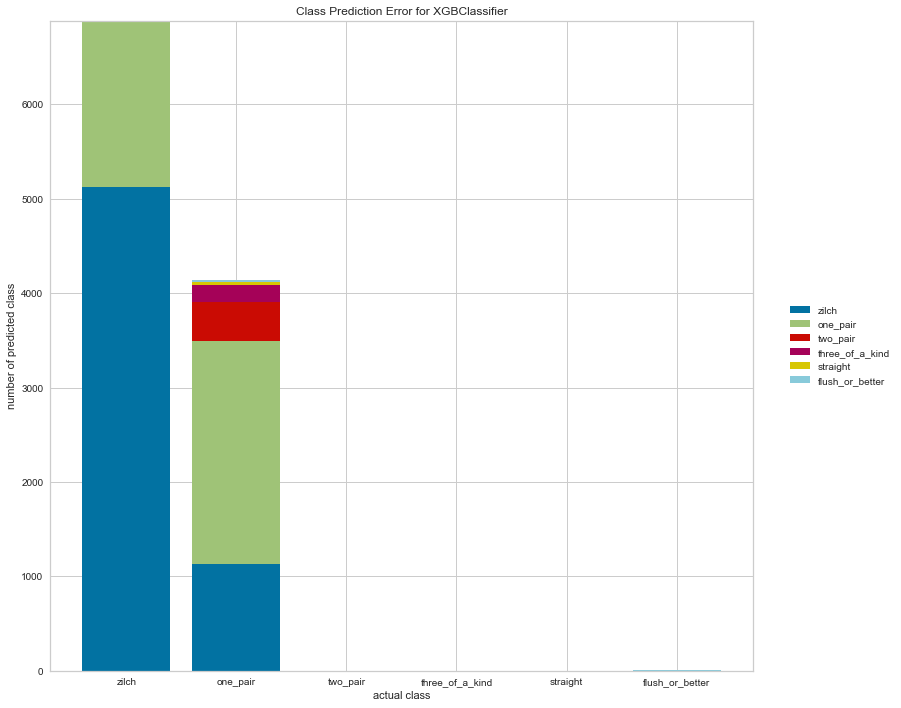

In [10]:
error = ClassPredictionError(clf, size=(1080, 720), classes=classes)

error.score(X_test, y_test)
e = error.poof()

## Conclusion

Clearly we still have some class imbalance issues with our particular dataset, even after binning the rare hands together into a single 'flush or better' class. But hopefully we've seen an effective and efficient workflow for testing out the efficacy of a prototype model and using Yellowbrick to visualize the results. 

I was really impressed when I discovered that Yellowbrick worked with `xgboost` out-of-the-box thanks to Tianqi's sklearn wrapper. If you know of other machine learning libraries that have sklearn wrappers (I'm thinking of Keras and Gensim, but I'm sure there are others), I would love to see whether Yellowbrick can be used with them for evaluation as well!